<a href="https://colab.research.google.com/github/Carlos-Muniz/debt-planner/blob/main/debt_planner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debt Planner

## Import packages

In [1]:
from numpy import random
from matplotlib import pyplot as plt

## Helper Functions

In [2]:
def totalLoans(loansAndRates):
    return round(sum([x for x, _, _ in loansAndRates]), 2)


def monthlyLoanGrowth(loansAndRates):
    newLR = []
    for l, r, id in loansAndRates:
        newLR.append([round(l*(1+r/12), 2), r, id])
    return newLR

def calculatePayment(x1, y1, x2, y2):
    return round(x1 - (x2*y2)/(y1), 2)


def assignIdentifiers(loansAndRates):
    p = 10**-2
    return [[s[0], s[1] * p, i] for i, s in enumerate(loansAndRates)]


def randomLoansAndRates(n=5):
    loansAndRates = []
    for i in range(n):
        loan = round(random.randint(1000,10000) + random.rand(), 2)
        rate = round(random.randint(3,20) + random.rand(), 2)
        loansAndRates.append((loan, rate))
    return loansAndRates


def graphResults(startingPoint, data):
    fig = plt.figure(figsize=(12,8))
    legend = []
    for d in data:
        (x, y, name, total) = d
        _ = plt.plot(x, y)
        legend.append(f"{name} @ ${total}")
    plt.xlabel("Months")
    plt.ylabel("Amount ($)")
    plt.title(f"Payment of ${startingPoint:.2f} in loans via a variety of methods")
    plt.legend(legend)
    plt.show()

## Payment Plans
Ways to pay loans:
1. Pay 100% of monthly payment to a randomly picked loan each month, if more payment than loan, randomly choose another loan.
2. Pay random amounts that add up to monthly payment, to a random selection of loans
3. Sort loans by highest rates and lowest loan amounts first, and pay off in order; also known as the "Snowball Method".
4. Sort loans by lowest rates and lowest loan amounts, and pay off in order.
5. Sort loans by highest interest owed, and pay off loans with most interest owed first.

In [3]:
# Random Loan Each Month
def randomMonthlyLoan(loansAndRates, periodicalPayment):
    n = len(loansAndRates)
    x = [i for i in range(n) if loansAndRates[i][0] > 0]
    c = random.choice(x)
    while loansAndRates[c][0] == 0 or periodicalPayment > 0:
        if periodicalPayment == 0:
            break
        if loansAndRates[c][0] > 0:
            amt = float(loansAndRates[c][0])
            loansAndRates[c][0] -= min(amt, periodicalPayment)
            periodicalPayment -= min(amt, periodicalPayment)
            x.remove(c)
        if not x:
            break
        c = random.choice(x)
    return [[round(l, 2), r, id] for l, r, id in loansAndRates]

In [4]:
# Random amounts to each random loan each month
def randomAmountRandomLoan(loansAndRates, periodicalPayment):
    n = len(loansAndRates)
    x = [i for i in range(n) if loansAndRates[i][0] > 0]
    c = random.choice(x)
    xLen = len(x)
    while periodicalPayment > 0:
        if loansAndRates[c][0] > 0:
            loansAndRates[c][0] -= 0.01
            periodicalPayment -= 0.01
        else:
            x.remove(c)
        if len(x) == 0:
            break
        if xLen != len(x):
            xLen = len(x)
        c = random.choice(x)
    return loansAndRates

In [5]:
# Pay off loans by highest interests first (Snowball Method)
def highestInterest(loansAndRates, periodicalPayment):
    lri = sorted([[r, l, id] for l, r, id in loansAndRates], reverse=True)
    ind = 0
    while periodicalPayment > 0 and ind < len(lri):
        amt = float(lri[ind][1])
        lri[ind][1] -= min(amt, periodicalPayment)
        periodicalPayment -= min(amt, periodicalPayment)
        ind += 1
    return [[round(l, 2), r, id] for r, l, id in lri]


In [6]:
# Pay off smallest loans by lowest interests first
def lowestInterest(loansAndRates, periodicalPayment):
    lri = sorted([[r, l, id] for l, r, id in loansAndRates])
    ind = 0
    while periodicalPayment > 0 and ind < len(lri):
        amt = float(lri[ind][1])
        lri[ind][1] -= min(amt, periodicalPayment)
        periodicalPayment -= min(amt, periodicalPayment)
        ind += 1
    return [[round(l, 2), r, id] for r, l, id in lri]

In [7]:
# Loans are payed by how much interest they are accruing
def interestOwed(loansAndRates, periodicalPayment):
    lri = sorted([[l*r, l, r, id] for l, r, id in loansAndRates], reverse=True)
    lri.append([0, 0, 1, -1])
    for i in range(len(lri) - 1):
        for j in range(i+1, 0, -1):
            _, x1, y1, id1 = lri[j-1]
            _, x2, y2, _ = lri[j]
            partialPayment = calculatePayment(x1, y1, x2, y2)
            lri[j-1][1] -= min(partialPayment, periodicalPayment)
            periodicalPayment -= min(partialPayment, periodicalPayment)
    return [[round(l, 2), r, id] for _, l, r, id in lri[:-1]]

## Monthly Simulator

In [8]:
# A way to simulate loan changes each month
def monthlySimulator(loansAndRates, paymentPerMonth, method):
    loansAndRates= assignIdentifiers(loansAndRates)
    months = [0]
    totals = [totalLoans(loansAndRates)]
    count = 500
    totalPayed = 0
    while (totals[-1] > 0 and count > 0):
        # print(f"{method.__name__} Month {months[-1]}: current total: {totals[-1]}")
        loansAndRates = method(loansAndRates, paymentPerMonth)
        loansAndRates = monthlyLoanGrowth(loansAndRates)
        totalPayed += min(paymentPerMonth, totals[-1])
        months.append(months[-1] + 1)
        totals.append(totalLoans(loansAndRates))
        count -= 1
    return months, totals, method.__name__, round(totalPayed, 2)

### Parameters

In [9]:
loansAndRates = randomLoansAndRates(10)
paymentPerMonth = 1500
methods = [
    randomMonthlyLoan,
    randomAmountRandomLoan,
    highestInterest,
    lowestInterest,
    interestOwed
]
sumOfLoans = round(sum([x for x, _ in loansAndRates]), 2)

In [10]:
results = []
for m in methods:
    results.append(monthlySimulator(loansAndRates, paymentPerMonth, m))

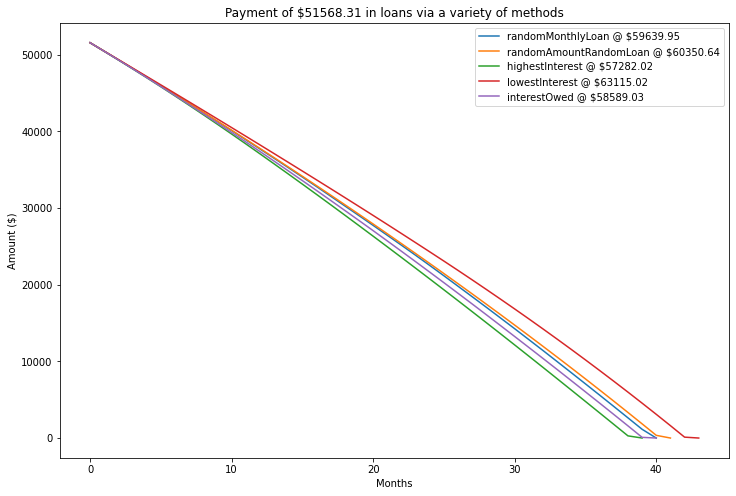

In [11]:
graphResults(sumOfLoans, results)